/var/folders/k3/hzgtpdx574g37s5jnbm3fgtr0000gn/T/ipykernel_64944/1047897955.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar_r')
/var/folders/k3/hzgtpdx574g37s5jnbm3fgtr0000gn/T/ipykernel_64944/1047897955.py:226: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


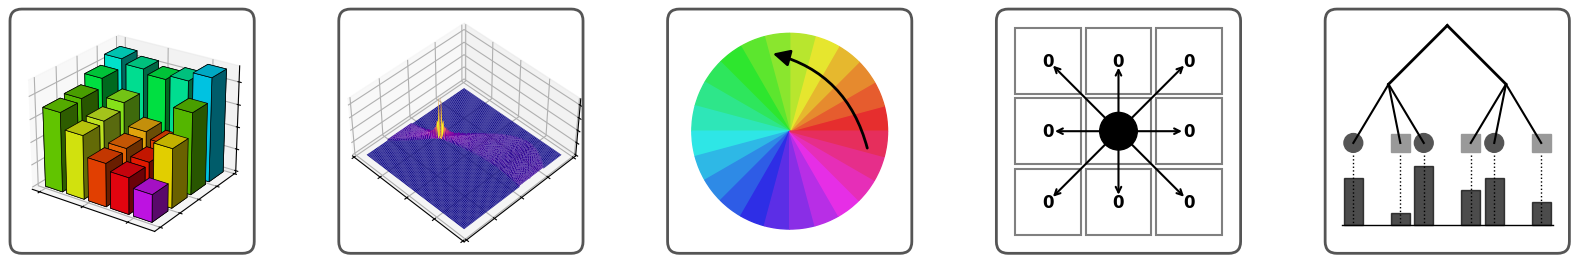

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import Normalize, hsv_to_rgb

def add_border_safe(fig, ax):
    """
    Adds a border. Handles 3D axes by creating a 2D overlay.
    Must be called AFTER plt.tight_layout().
    """
    # 1. Determine the bounding box of the subplot
    # (We use the bbox of the existing axis to place the border)
    pos = ax.get_position()
    
    # 2. If it's a 3D axis, we cannot add 2D patches directly.
    #    We create a transparent 2D axis explicitly for the border on top.
    if ax.name == '3d':
        # Create a new 2D axes covering the exact same area
        rect_ax = fig.add_axes(pos)
        rect_ax.set_axis_off() # Hide the internal grid/ticks of this overlay
        rect_ax.set_xlim(0, 1)
        rect_ax.set_ylim(0, 1)
        target_ax = rect_ax
    else:
        # If it's 2D, we can just add the patch to it directly
        target_ax = ax

    # 3. Create and add the FancyBboxPatch
    rect = patches.FancyBboxPatch(
        (0, 0), 1, 1,
        boxstyle="round,pad=0.02,rounding_size=0.05",
        linewidth=2, edgecolor='#555555', facecolor='none',
        transform=target_ax.transAxes, clip_on=False, zorder=100
    )
    target_ax.add_patch(rect)


def create_final_icon_strip_fixed():
    fig = plt.figure(figsize=(20, 4))
    
    # Store axes to apply borders later
    all_axes = []

    # =========================================================================
    # 1. HOG (3D Bar Chart)
    # =========================================================================
    ax1 = fig.add_subplot(1, 5, 1, projection='3d')
    all_axes.append(ax1)

    # Data
    data = np.array([
        [17.5, 14.0, 9.5, 8.0, 6.0],
        [18.0, 14.5, 10.0, 8.5, 13.0],
        [20.0, 16.0, 11.0, 9.5, 18.0],
        [22.0, 21.0, 20.0, 21.0, 23.0]
    ])
    
    _x = np.arange(5)
    _y = np.arange(4)
    xpos, ypos = np.meshgrid(_x, _y)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like(xpos)
    dx = 0.8 * np.ones_like(zpos)
    dy = 0.8 * np.ones_like(zpos)
    dz = data.flatten()

    cmap = plt.cm.get_cmap('gist_ncar_r') 
    norm = Normalize(vmin=dz.min() - 5, vmax=dz.max() + 5)
    colors = cmap(norm(dz))

    ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, edgecolor='black', linewidth=0.5, shade=True)

    # HOG Styling
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.view_init(elev=25, azim=-55)
    ax1.set_box_aspect((1, 1, 0.8))


    # =========================================================================
    # 2. Hough Transform (3D Accumulator)
    # =========================================================================
    ax2 = fig.add_subplot(1, 5, 2, projection='3d')
    all_axes.append(ax2)

    # Data
    img_size = 64
    image = np.zeros((img_size, img_size))
    for i in range(10, 54):
        image[i, i] = 1

    thetas = np.deg2rad(np.arange(-90, 90))
    width, height = image.shape
    diag_len = int(np.ceil(np.sqrt(width**2 + height**2)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Hough Calculation
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(image)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(num_thetas):
            rho_val = x * cos_t[t_idx] + y * sin_t[t_idx]
            rho_idx = int(round(rho_val)) + diag_len
            accumulator[rho_idx, t_idx] += 1

    X, Y = np.meshgrid(np.rad2deg(thetas), rhos)
    Z = accumulator
    
    # Plot
    ax2.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', rstride=2, cstride=2, shade=True)

    # Hough Styling
    ax2.grid(True)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_zticklabels([])
    ax2.set_box_aspect((1, 1, 0.5))
    ax2.view_init(elev=45, azim=-45)


    # =========================================================================
    # 3. HSV Stats (Color Wheel)
    # =========================================================================
    ax3 = fig.add_subplot(1, 5, 3)
    all_axes.append(ax3)
    ax3.set_aspect('equal')
    ax3.axis('off')
    ax3.set_xlim(-6, 6)
    ax3.set_ylim(-6, 6)

    N = 24
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    wedge_width = (2 * np.pi) / N
    radii = 5.0

    for t in theta:
        color = hsv_to_rgb([t / (2*np.pi), 0.8, 0.9])
        wedge = patches.Wedge((0,0), radii, np.rad2deg(t), np.rad2deg(t + wedge_width), color=color)
        ax3.add_patch(wedge)

    arrow_patch = patches.FancyArrowPatch((4.0, -1), (-1, 4.0), connectionstyle="arc3,rad=0.3", 
                                          arrowstyle='-|>', mutation_scale=25, fc='k', ec='k', lw=2)
    ax3.add_patch(arrow_patch)


    # =========================================================================
    # 4. LBP (Grid)
    # =========================================================================
    ax4 = fig.add_subplot(1, 5, 4)
    all_axes.append(ax4)
    ax4.set_aspect('equal')
    ax4.axis('off')
    ax4.set_xlim(0, 10)
    ax4.set_ylim(0, 10)
    
    xs = [2, 5, 8]
    ys = [2, 5, 8]
    cx, cy = 5, 5
    
    for x in xs:
        for y in ys:
            rect = patches.Rectangle((x-1.4, y-1.4), 2.8, 2.8, linewidth=1.5, edgecolor='gray', facecolor='none')
            ax4.add_patch(rect)
            if x != cx or y != cy:
                ax4.annotate("", xy=(x, y), xytext=(cx, cy),
                            arrowprops=dict(arrowstyle="->", lw=1.5, color='black', shrinkA=5, shrinkB=5))
                label = "1" if (x+y) % 3 == 0 else "0"
                ax4.text(x, y, label, fontsize=12, ha='center', va='center', fontweight='bold')

    circle = patches.Circle((cx, cy), 0.8, color='black')
    ax4.add_patch(circle)


    # =========================================================================
    # 5. Dense-SIFT BoVW (Tree + Hist)
    # =========================================================================
    ax5 = fig.add_subplot(1, 5, 5)
    all_axes.append(ax5)
    ax5.set_aspect('equal')
    ax5.axis('off')
    ax5.set_xlim(0, 10)
    ax5.set_ylim(0, 10)

    root = (5, 9.5)
    branch_l = (2.5, 7.0)
    branch_r = (7.5, 7.0)
    leaves = [(1, 4.5), (3, 4.5), (4, 4.5), (6, 4.5), (7, 4.5), (9, 4.5)]
    
    ax5.plot([root[0], branch_l[0]], [root[1], branch_l[1]], 'k-', lw=2)
    ax5.plot([root[0], branch_r[0]], [root[1], branch_r[1]], 'k-', lw=2)
    
    for i, leaf in enumerate(leaves):
        parent = branch_l if i < 3 else branch_r
        ax5.plot([parent[0], leaf[0]], [parent[1], leaf[1]], 'k-', lw=1.5)
        if i % 2 == 0:
             patch = patches.Circle(leaf, 0.4, color='#555555')
        else:
             patch = patches.Rectangle((leaf[0]-0.4, leaf[1]-0.4), 0.8, 0.8, color='#999999')
        ax5.add_patch(patch)

    hist_base_y = 1.0
    hist_heights = [2.0, 0.5, 2.5, 1.5, 2.0, 1.0]
    bar_width = 0.8
    
    for i, h in enumerate(hist_heights):
        leaf_x = leaves[i][0]
        ax5.plot([leaf_x, leaf_x], [4.0, hist_base_y], 'k:', lw=1)
        rect = patches.Rectangle((leaf_x - bar_width/2, hist_base_y), 
                                 bar_width, h, color='black', alpha=0.7)
        ax5.add_patch(rect)

    ax5.plot([0.5, 9.5], [hist_base_y, hist_base_y], 'k-', lw=1)
    

    # --- FINALIZATION ---
    # 1. First adjust the layout to finalize positions
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4) # Add breathing room between boxes
    
    # 2. NOW add the borders. 
    # Because tight_layout moved the axes, we must get positions now.
    for ax in all_axes:
        add_border_safe(fig, ax)

    plt.savefig('final_vision_icons_fixed.svg', format='svg', bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    create_final_icon_strip_fixed()